Import libraries

In [2]:
import numpy as np
import pathlib
import cv2 
import PIL.Image as Image 
import os 
import matplotlib.pylab as plt
import shutil
import glob 
import imageio 
import sklearn
import tensorflow as tf 
import tensorflow_hub as hub
from statistics import mean
from tensorflow import keras 
from tensorflow.keras import layers 
from tensorflow.keras.models import Sequential 
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense
from sklearn import svm
from scipy import misc 



'\nTestTrain = np.array([])\nfor im_path in glob.glob("./data1/*.png"):\n    img = imageio.imread(im_path)\n    img = Image.fromarray(img).convert("RGB")\n    #img = img.rotate(90)\n    #img.save(\'./1test_test.jpeg\')\n    #img = np.array(img)\n    TestTrain = np.append(TestTrain, (img,0))\n    print(type(img))\n    #img = img.convert("RGBA").convert("RGB")\n    #img = cv2.resize(img, (224, 224)) #img = np.expand_dims(img, axis=0) print(img.shape) # do whatever with the image here print(4)\n'

dividing images into test and train folders (0.2/0.8)

In [66]:
classes = ["Ak","Ala_Idris","Buzgulu","Dimnit","Nazli"]
rootdir="./"
for i in classes:

  os.makedirs(rootdir +'/train/' + i)
  os.makedirs(rootdir +'/test/' + i)
  source = rootdir + '/' + i

  allFileNames = os.listdir(source)
  np.random.shuffle(allFileNames)
  test_ratio = 0.2
  train_FileNames, test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)* (1 - test_ratio))])

  train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
  test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]

  for name in train_FileNames:
    shutil.copy(name, rootdir +'/train/' + i)

  for name in test_FileNames:
    shutil.copy(name, rootdir +'/test/' + i)

**1st Classification Model**

In this method, we create a CNN with 5 layers as follows. (Model is trained with 45 epochs) 

loading data

In [2]:
data_dir = pathlib.Path("./")
images_dict = {
    'Ak': list(data_dir.glob('Ak/*')),
    "Ala_Idris": list(data_dir.glob('Ala_Idris/*')),
    "Buzgulu": list(data_dir.glob('Buzgulu/*')),
    "Dimnit": list(data_dir.glob('Dimnit/*')),
    'Nazli': list(data_dir.glob('Nazli/*')),
}

labels_dict = {
    'Ak': 0,
    "Ala_Idris": 1,
    "Buzgulu": 2,
    "Dimnit": 3,
    'Nazli': 4,
}

resizing and loading on X and y

In [3]:
X, y = [], []


for name, images in images_dict.items():
    for image in images:
        img = imageio.imread(str(image))
        img = Image.fromarray(img).convert("RGB")
        img = np.array(img)
        #resize images
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(labels_dict[name])

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4464\2189021723.py:6: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(str(image))


In [4]:
X = np.array(X)
y = np.array(y)

train and test spliting (.8/.2) and normalizing

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=21)

In [6]:
X_train_scaled = X_train / 224
X_test_scaled = X_test / 224

In [129]:
print(len(X_train_scaled),len(X_test_scaled))

375 125


Build the model and fit training data on it.

In [27]:
num_classes = 5

model1 = Sequential([
  layers.Conv2D(4, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(9, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model1.fit(X_train_scaled, y_train, epochs=45)        

Epoch 1/45
12/12 [==============================] - 5s 382ms/step - loss: 1.6069 - accuracy: 0.2027
Epoch 2/45
12/12 [==============================] - 4s 342ms/step - loss: 1.5249 - accuracy: 0.3600
Epoch 3/45
12/12 [==============================] - 5s 387ms/step - loss: 1.2714 - accuracy: 0.4773
Epoch 4/45
12/12 [==============================] - 4s 360ms/step - loss: 0.9846 - accuracy: 0.6267
Epoch 5/45
12/12 [==============================] - 4s 368ms/step - loss: 0.8654 - accuracy: 0.6933
Epoch 6/45
12/12 [==============================] - 4s 369ms/step - loss: 0.7137 - accuracy: 0.7147
Epoch 7/45
12/12 [==============================] - 5s 398ms/step - loss: 0.5926 - accuracy: 0.7813
Epoch 8/45
12/12 [==============================] - 5s 390ms/step - loss: 0.4983 - accuracy: 0.8053
Epoch 9/45
12/12 [==============================] - 5s 366ms/step - loss: 0.3772 - accuracy: 0.8400
Epoch 10/45
12/12 [==============================] - 5s 406ms/step - loss: 0.3387 - accuracy: 0.8853

Calcute the accuracy on test set

In [28]:
model1.evaluate(X_test_scaled,y_test)

4/4 [==============================] - 1s 103ms/step - loss: 5.0877 - accuracy: 0.5200


[5.087723255157471, 0.5199999809265137]

**2nd Classification Model**

For this method, the data of the most part is augmented. To augment images, we perform several different fuvtions such as horizontal filp, trasfering, zooming and rotation.

Augmentation of images is preformed by the help of a sequential neural network; we create a new network so that several primary layers are superimposed on the image augmentation and later layers according to the primary network architecture. Therefore, in this architecture, we fit the initial model on the augmented images. (In this method, unlike the previous method, we use 150 epochs, because the model made of augmented images is less threatened by overfit.)

defining augmentation method

In [37]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(224,224,3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    #layers.experimental.preprocessing.RandomTranslation(1., 1.),
  ]
)

Build the model and fit the training set on it

In [39]:
num_classes = 5

model2 = Sequential([
  data_augmentation,
  layers.Conv2D(4, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(9, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

model2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
              
model2.fit(X_train_scaled, y_train, epochs=150)    

Epoch 1/150
4/4 [==============================] - 4s 529ms/step - loss: 1.8386 - accuracy: 0.1800
Epoch 2/150
4/4 [==============================] - 2s 547ms/step - loss: 1.6298 - accuracy: 0.2000
Epoch 3/150
4/4 [==============================] - 2s 554ms/step - loss: 1.6119 - accuracy: 0.2000
Epoch 4/150


KeyboardInterrupt: 

In [41]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 4)       112       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 4)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 9)       333       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 9)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)       

Calculate the accuracy

In [56]:
model2.evaluate(X_test_scaled,y_test)

4/4 [==============================] - 1s 93ms/step - loss: 1.8176 - accuracy: 0.6560


[1.8175956010818481, 0.656000018119812]

**3rd Classification Model**

In this method, we use the pre-trained MobileNetv2 model after being fine tuned. So that a classification layer is added and only the weights leading to the last layer are traind.
For this method, it is necessary that the number of pixels in length and width be equal to the input of the pre-traind moreover, the images should be three-channeled, which we obtain by resizing the input images. It should be noted that in this method, the input images are not augmented.

In [24]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [25]:
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

OSError: SavedModel file does not exist at: C:\Users\lenovo\AppData\Local\Temp\tfhub_modules\145bb06ec3b59b08fb564ab752bd5aa222bfb50a\{saved_model.pbtxt|saved_model.pb}

In [61]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_36 (Dense)            (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [64]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
12/12 [==============================] - 9s 656ms/step - loss: 0.3879 - acc: 0.8933
Epoch 2/100
12/12 [==============================] - 7s 616ms/step - loss: 0.3651 - acc: 0.9200
Epoch 3/100
12/12 [==============================] - 7s 615ms/step - loss: 0.3419 - acc: 0.9147
Epoch 4/100
12/12 [==============================] - 7s 599ms/step - loss: 0.3153 - acc: 0.9280
Epoch 5/100
12/12 [==============================] - 7s 618ms/step - loss: 0.2861 - acc: 0.9520
Epoch 6/100
12/12 [==============================] - 8s 628ms/step - loss: 0.2695 - acc: 0.9573
Epoch 7/100
12/12 [==============================] - 7s 615ms/step - loss: 0.2545 - acc: 0.9573
Epoch 8/100
12/12 [==============================] - 7s 616ms/step - loss: 0.2472 - acc: 0.9520
Epoch 9/100
12/12 [==============================] - 8s 658ms/step - loss: 0.2334 - acc: 0.9573
Epoch 10/100
12/12 [==============================] - 8s 636ms/step - loss: 0.2197 - acc: 0.9733
Epoch 11/100
12/12 [===================

In [ ]:
Calculating the accuracy of the model

In [65]:
model.evaluate(X_test_scaled,y_test)

4/4 [==============================] - 3s 604ms/step - loss: 0.4035 - acc: 0.8640


[0.40345901250839233, 0.8640000224113464]

**4th Classification Model**

In this method, we try to involve a layer with the ability to augment data in the third method. So that before the images enter the pre-trained MobileNetv2 network, they pass through layers to be augmented. By using this method, we can increase the number of epochs without fear of having an overfited model.

In [83]:
num_of_flowers = 5

model4 = tf.keras.Sequential([
  data_augmentation,
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model4.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_23 (Sequential)  (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_40 (Dense)            (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [93]:
model4.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model4.fit(X_train_scaled, y_train, epochs=120)

Epoch 1/120
12/12 [==============================] - 10s 671ms/step - loss: 0.2647 - acc: 0.9227
Epoch 2/120
12/12 [==============================] - 8s 688ms/step - loss: 0.2799 - acc: 0.9280
Epoch 3/120
12/12 [==============================] - 8s 660ms/step - loss: 0.2636 - acc: 0.9227
Epoch 4/120
12/12 [==============================] - 8s 689ms/step - loss: 0.2319 - acc: 0.9333
Epoch 5/120
12/12 [==============================] - 8s 691ms/step - loss: 0.2277 - acc: 0.9360
Epoch 6/120
12/12 [==============================] - 8s 689ms/step - loss: 0.2451 - acc: 0.9413
Epoch 7/120
12/12 [==============================] - 9s 708ms/step - loss: 0.2401 - acc: 0.9440
Epoch 8/120
12/12 [==============================] - 9s 705ms/step - loss: 0.2513 - acc: 0.9013
Epoch 9/120
12/12 [==============================] - 9s 721ms/step - loss: 0.2352 - acc: 0.9253
Epoch 10/120
12/12 [==============================] - 8s 675ms/step - loss: 0.1987 - acc: 0.9413
Epoch 11/120
12/12 [==================

In [94]:
model4.evaluate(X_test_scaled,y_test)

4/4 [==============================] - 3s 646ms/step - loss: 0.6374 - acc: 0.7600


[0.63736891746521, 0.7599999904632568]

**5th Classification Model**

First, we use the state-of-art 16VGG as feature extractor. Then we use the output of the last layer of the pre-learned model for the input of the RFC and the SVC with different parameters.

In [8]:
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
VGG_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
feature_extractor=VGG_model.predict(X_train_scaled)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

12/12 [==============================] - 47s 4s/step


In [14]:
from sklearn.ensemble import RandomForestClassifier
RF_model1 = RandomForestClassifier(n_estimators = 10, random_state = 42)
RF_model2 = RandomForestClassifier(n_estimators = 50, random_state = 43)
RF_model3 = RandomForestClassifier(n_estimators = 70, random_state = 44)
SVM1 = svm.SVC(kernel='poly', degree=5, C=3)
SVM2 = svm.SVC(kernel='poly', degree=3, C=1)
SVM3 = svm.SVC(kernel='poly', degree=6, C=1)

In [18]:
# Train the model on training data
RF_model1.fit(features, y_train)
RF_model2.fit(features, y_train)
RF_model3.fit(features, y_train)
SVM1.fit(features, y_train)
SVM2.fit(features, y_train)
SVM3.fit(features, y_train)

SVC(C=1, degree=6, kernel='poly')

In [22]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test_scaled)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)


#Predict using the trained RF model. 
prediction_RF1 = RF_model1.predict(X_test_features)
prediction_RF2 = RF_model2.predict(X_test_features)
prediction_RF3 = RF_model3.predict(X_test_features)
prediction_SVM1 = SVM1.predict(X_test_features)
prediction_SVM2 = SVM2.predict(X_test_features)
prediction_SVM3 = SVM3.predict(X_test_features)

4/4 [==============================] - 25s 6s/step


In [23]:
from sklearn import metrics
print ("RF1 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF1))
print ("RF2 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF2))
print ("RF3 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF3))
print ("SVM1 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM1))
print ("SVM2 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM2))
print ("SVM3 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM3))

RF1 Accuracy =  0.608
RF2 Accuracy =  0.752
RF3 Accuracy =  0.672
SVM1 Accuracy =  0.856
SVM2 Accuracy =  0.8
SVM3 Accuracy =  0.84


**Classification 6**

In the previous method, 25088 (the size of VGG16 classes) features are extracted and given to the classifiers. This amount is much lower than 365, which is the number of Images (without augmentation), so PCA method is used to reduce the dimensions of the model output -as a feature selector. It should be noted that due to the input limitation, a maximum of 365 different attributes can be kept. We run PCA four times and each time we keep 365, 200, 100 and 50 attributes respectively.

In [27]:
feature_extractor=VGG_model.predict(X_train_scaled)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

12/12 [==============================] - 92s 8s/step


In [28]:
from sklearn.decomposition import PCA
number_of_PCA = 375
print("number of total features was ",len(features[0])," and reduced to ",number_of_PCA)
pca = PCA(n_components=number_of_PCA)
pca.fit(features)
ex_features = pca.transform(features)

number of total features was  25088  and reduced to  375


In [29]:
# Train the model on training data
RF_model1.fit(ex_features, y_train)
RF_model2.fit(ex_features, y_train)
RF_model3.fit(ex_features, y_train)
SVM1.fit(ex_features, y_train)
SVM2.fit(ex_features, y_train)
SVM3.fit(ex_features, y_train)

SVC(C=1, degree=6, kernel='poly')

In [32]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test_scaled)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
ex_X_test_features =  pca.transform(X_test_features)

#Predict using the trained RF model. 
prediction_RF1 = RF_model1.predict(ex_X_test_features)
prediction_RF2 = RF_model2.predict(ex_X_test_features)
prediction_RF3 = RF_model3.predict(ex_X_test_features)
prediction_SVM1 = SVM1.predict(ex_X_test_features)
prediction_SVM2 = SVM2.predict(ex_X_test_features)
prediction_SVM3 = SVM3.predict(ex_X_test_features)

4/4 [==============================] - 41s 10s/step


In [33]:
print ("RF1 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF1))
print ("RF2 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF2))
print ("RF3 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF3))
print ("SVM1 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM1))
print ("SVM2 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM2))
print ("SVM3 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM3))

RF1 Accuracy =  0.392
RF2 Accuracy =  0.648
RF3 Accuracy =  0.712
SVM1 Accuracy =  0.312
SVM2 Accuracy =  0.52
SVM3 Accuracy =  0.168


**Classification 6.1**

In [35]:
feature_extractor=VGG_model.predict(X_train_scaled)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

12/12 [==============================] - 105s 9s/step


In [36]:
number_of_PCA = 200
print("number of total features was ",len(features[0])," and reduced to ",number_of_PCA)
pca = PCA(n_components=number_of_PCA)
pca.fit(features)
ex_features = pca.transform(features)

number of total features was  25088  and reduced to  200


In [37]:
# Train the model on training data
RF_model1.fit(ex_features, y_train)
RF_model2.fit(ex_features, y_train)
RF_model3.fit(ex_features, y_train)
SVM1.fit(ex_features, y_train)
SVM2.fit(ex_features, y_train)
SVM3.fit(ex_features, y_train)

SVC(C=1, degree=6, kernel='poly')

In [39]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test_scaled)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
ex_X_test_features =  pca.transform(X_test_features)

#Predict using the trained RF model. 
prediction_RF1 = RF_model1.predict(ex_X_test_features)
prediction_RF2 = RF_model2.predict(ex_X_test_features)
prediction_RF3 = RF_model3.predict(ex_X_test_features)
prediction_SVM1 = SVM1.predict(ex_X_test_features)
prediction_SVM2 = SVM2.predict(ex_X_test_features)
prediction_SVM3 = SVM3.predict(ex_X_test_features)

4/4 [==============================] - 37s 9s/step


In [40]:
print ("RF1 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF1))
print ("RF2 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF2))
print ("RF3 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF3))
print ("SVM1 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM1))
print ("SVM2 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM2))
print ("SVM3 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM3))

RF1 Accuracy =  0.496
RF2 Accuracy =  0.76
RF3 Accuracy =  0.72
SVM1 Accuracy =  0.304
SVM2 Accuracy =  0.6
SVM3 Accuracy =  0.168


**Classification 6.2**

In [42]:
feature_extractor=VGG_model.predict(X_train_scaled)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

12/12 [==============================] - 112s 9s/step


In [43]:
number_of_PCA = 100
print("number of total features was ",len(features[0])," and reduced to ",number_of_PCA)
pca = PCA(n_components=number_of_PCA)
pca.fit(features)
ex_features = pca.transform(features)

number of total features was  25088  and reduced to  100


In [44]:
# Train the model on training data
RF_model1.fit(ex_features, y_train)
RF_model2.fit(ex_features, y_train)
RF_model3.fit(ex_features, y_train)
SVM1.fit(ex_features, y_train)
SVM2.fit(ex_features, y_train)
SVM3.fit(ex_features, y_train)

SVC(C=1, degree=6, kernel='poly')

In [45]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test_scaled)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
ex_X_test_features =  pca.transform(X_test_features)

#Predict using the trained RF model. 
prediction_RF1 = RF_model1.predict(ex_X_test_features)
prediction_RF2 = RF_model2.predict(ex_X_test_features)
prediction_RF3 = RF_model3.predict(ex_X_test_features)
prediction_SVM1 = SVM1.predict(ex_X_test_features)
prediction_SVM2 = SVM2.predict(ex_X_test_features)
prediction_SVM3 = SVM3.predict(ex_X_test_features)

4/4 [==============================] - 40s 10s/step


In [46]:
print ("RF1 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF1))
print ("RF2 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF2))
print ("RF3 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF3))
print ("SVM1 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM1))
print ("SVM2 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM2))
print ("SVM3 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM3))

RF1 Accuracy =  0.536
RF2 Accuracy =  0.736
RF3 Accuracy =  0.76
SVM1 Accuracy =  0.44
SVM2 Accuracy =  0.696
SVM3 Accuracy =  0.216


**Classification 6.3**

In [68]:
feature_extractor=VGG_model.predict(X_train_scaled)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

12/12 [==============================] - 48s 4s/step


In [72]:
features.shape

(375, 25088)

In [89]:
number_of_PCA = 200
print("number of total features was ",len(features[0])," and reduced to ",number_of_PCA)
pca = PCA(n_components=number_of_PCA)
pca.fit(features)
ex_features = pca.transform(features)

number of total features was  25088  and reduced to  200


In [90]:
# Train the model on training data
RF_model1.fit(ex_features, y_train)
RF_model2.fit(ex_features, y_train)
RF_model3.fit(ex_features, y_train)
SVM1.fit(ex_features, y_train)
SVM2.fit(ex_features, y_train)
SVM3.fit(ex_features, y_train)

ValueError: Found input variables with inconsistent numbers of samples: [750, 375]

In [51]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test_scaled)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
ex_X_test_features =  pca.transform(X_test_features)

#Predict using the trained RF model. 
prediction_RF1 = RF_model1.predict(ex_X_test_features)
prediction_RF2 = RF_model2.predict(ex_X_test_features)
prediction_RF3 = RF_model3.predict(ex_X_test_features)
prediction_SVM1 = SVM1.predict(ex_X_test_features)
prediction_SVM2 = SVM2.predict(ex_X_test_features)
prediction_SVM3 = SVM3.predict(ex_X_test_features)

4/4 [==============================] - 54s 13s/step


In [52]:
print ("RF1 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF1))
print ("RF2 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF2))
print ("RF3 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF3))
print ("SVM1 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM1))
print ("SVM2 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM2))
print ("SVM3 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM3))

RF1 Accuracy =  0.632
RF2 Accuracy =  0.784
RF3 Accuracy =  0.776
SVM1 Accuracy =  0.528
SVM2 Accuracy =  0.752
SVM3 Accuracy =  0.256


**Classification 7**

The weak part of the previous model was not having a large number of inputs, which made the comparison of PCA dimensions meaningless. In the seventh method, we follow the sequence of the sixth method, with the difference that we attach a neural network to the top of VGG16 to augment the input data and input the previous data four times (augment the data four times), so we have the 1500 most input. We check thirteen different modes for the number of features. Some of the results of the implementation of these dimension reductions on the six previously introduced models are shown in the figure below, and the accuracy diagram of the models according to the dimension reduction is shown below:

In [55]:
model7 = Sequential([
  data_augmentation,
  VGG_model])  

model7.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
Total params: 14,714,688
Trainable params: 0
Non-trainable params: 14,714,688
_________________________________________________________________


In [9]:
feature_extractor=VGG_model.predict(X_train_scaled)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)
for i in range(3):
    feature_extractor=VGG_model.predict(X_train_scaled)
    f2 = feature_extractor.reshape(feature_extractor.shape[0], -1)
    features = np.concatenate([features,feature_extractor.reshape(feature_extractor.shape[0], -1)])

12/12 [==============================] - 56s 5s/step


In [11]:
ex_y_train = np.concatenate([y_train, y_train])
ex_y_train = np.concatenate([ex_y_train, ex_y_train])

In [12]:
print(len(ex_y_train))
print(len(features))

1500
1500


In [225]:
RF_model1 = RandomForestClassifier(n_estimators = 10, random_state = 42)
RF_model2 = RandomForestClassifier(n_estimators = 50, random_state = 43)
RF_model3 = RandomForestClassifier(n_estimators = 70, random_state = 44)
SVM1 = svm.SVC(kernel='poly', degree=5, C=3)
SVM2 = svm.SVC(kernel='poly', degree=3, C=1)
SVM3 = svm.SVC(kernel='poly', degree=6, C=1)

In [226]:
# Train the model on training data
RF_model1.fit(features, ex_y_train)
RF_model2.fit(features, ex_y_train)
RF_model3.fit(features, ex_y_train)
SVM1.fit(features, ex_y_train)
SVM2.fit(features, ex_y_train)
SVM3.fit(features, ex_y_train)

SVC(C=1, degree=6, kernel='poly')

In [227]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test_scaled)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

#Now predict using the trained RF model. 
prediction_RF1 = RF_model1.predict(X_test_features)
prediction_RF2 = RF_model2.predict(X_test_features)
prediction_RF3 = RF_model3.predict(X_test_features)
prediction_SVM1 = SVM1.predict(X_test_features)
prediction_SVM2 = SVM2.predict(X_test_features)
prediction_SVM3 = SVM3.predict(X_test_features)

4/4 [==============================] - 18s 4s/step


In [228]:
print ("RF1 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF1))
print ("RF2 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF2))
print ("RF3 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF3))
print ("SVM1 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM1))
print ("SVM2 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM2))
print ("SVM3 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM3))
#graph_vec1, graph_vec2, graph_vec3, graph_vec4, graph_vec5, graph_vec6 = [["all", metrics.accuracy_score(y_test, prediction_RF1)]],  [["all", metrics.accuracy_score(y_test, prediction_RF2)]], [["all", metrics.accuracy_score(y_test, prediction_RF3)]], [["all", metrics.accuracy_score(y_test, prediction_SVM1)]],[["all", metrics.accuracy_score(y_test, prediction_SVM2)]], [["all", metrics.accuracy_score(y_test, prediction_SVM3)]]

RF1 Accuracy =  0.64
RF2 Accuracy =  0.76
RF3 Accuracy =  0.824
SVM1 Accuracy =  0.856
SVM2 Accuracy =  0.848
SVM3 Accuracy =  0.856


In [182]:
for number_of_PCA in [1500,1000,750,500,300,200,100,50,40,30,20,10,5]:
    print("number of total features was ",len(features[0])," and reduced to ",number_of_PCA)
    pca = PCA(n_components=number_of_PCA)
    pca.fit(features)
    ex_features = pca.transform(features)

    # Train the model on training data
    RF_model1.fit(ex_features, ex_y_train)
    RF_model2.fit(ex_features, ex_y_train)
    RF_model3.fit(ex_features, ex_y_train)
    SVM1.fit(ex_features, ex_y_train)
    SVM2.fit(ex_features, ex_y_train)
    SVM3.fit(ex_features, ex_y_train)

    #Send test data through same feature extractor process
    X_test_feature = VGG_model.predict(X_test_scaled)
    X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
    ex_X_test_features =  pca.transform(X_test_features)

    #Now predict using the trained RF model. 
    prediction_RF1 = RF_model1.predict(ex_X_test_features)
    prediction_RF2 = RF_model2.predict(ex_X_test_features)
    prediction_RF3 = RF_model3.predict(ex_X_test_features)
    prediction_SVM1 = SVM1.predict(ex_X_test_features)
    prediction_SVM2 = SVM2.predict(ex_X_test_features)
    prediction_SVM3 = SVM3.predict(ex_X_test_features)

    print ("RF1 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF1))
    print ("RF2 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF2))
    print ("RF3 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF3))
    print ("SVM1 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM1))
    print ("SVM2 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM2))
    print ("SVM3 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM3))
    
    graph_vec1.append([metrics.accuracy_score(y_test, prediction_RF1),number_of_PCA])
    graph_vec2.append([metrics.accuracy_score(y_test, prediction_RF2),number_of_PCA])
    graph_vec3.append([metrics.accuracy_score(y_test, prediction_RF3),number_of_PCA])
    graph_vec4.append([metrics.accuracy_score(y_test, prediction_SVM1),number_of_PCA])
    graph_vec5.append([metrics.accuracy_score(y_test, prediction_SVM2),number_of_PCA])
    graph_vec6.append([metrics.accuracy_score(y_test, prediction_SVM3),number_of_PCA])

number of total features was  25088  and reduced to  1500
4/4 [==============================] - 19s 5s/step
RF1 Accuracy =  0.296
RF2 Accuracy =  0.304
RF3 Accuracy =  0.336
SVM1 Accuracy =  0.384
SVM2 Accuracy =  0.776
SVM3 Accuracy =  0.248
number of total features was  25088  and reduced to  1000
4/4 [==============================] - 18s 4s/step
RF1 Accuracy =  0.344
RF2 Accuracy =  0.472
RF3 Accuracy =  0.56
SVM1 Accuracy =  0.384
SVM2 Accuracy =  0.776
SVM3 Accuracy =  0.248
number of total features was  25088  and reduced to  750
4/4 [==============================] - 19s 5s/step
RF1 Accuracy =  0.328
RF2 Accuracy =  0.632
RF3 Accuracy =  0.6
SVM1 Accuracy =  0.384
SVM2 Accuracy =  0.776
SVM3 Accuracy =  0.248
number of total features was  25088  and reduced to  500
4/4 [==============================] - 19s 5s/step
RF1 Accuracy =  0.328
RF2 Accuracy =  0.616
RF3 Accuracy =  0.624
SVM1 Accuracy =  0.384
SVM2 Accuracy =  0.776
SVM3 Accuracy =  0.248
number of total features was 

In [274]:
import matplotlib.pyplot as plt
plt.close('all')
plt.plot(np.array(graph_vec1)[:,1],np.array(graph_vec1)[:,0].astype(float),label="RF1 Accuracy")
plt.plot(np.array(graph_vec2)[:,1],np.array(graph_vec2)[:,0].astype(float),label="RF2 Accuracy")
plt.plot(np.array(graph_vec3)[:,1],np.array(graph_vec3)[:,0].astype(float),label="RF3 Accuracy")
plt.plot(np.array(graph_vec4)[:,1],np.array(graph_vec4)[:,0].astype(float),label="SVM1 Accuracy")
plt.plot(np.array(graph_vec5)[:,1],np.array(graph_vec5)[:,0].astype(float),label="SVM2 Accuracy")
plt.plot(np.array(graph_vec6)[:,1],np.array(graph_vec6)[:,0].astype(float),label="SVM3 Accuracy")
plt.figure(figsize=(254, 6))
plt.legend()
plt.show()

TypeError: 'int' object is not subscriptable

In [253]:
(graph_vec1)[0][0]=0.64
(graph_vec2)[0][0]=0.76
(graph_vec3)[0][0]=0.824
(graph_vec4)[0][0]=0.856
(graph_vec5)[0][0]=0.848
(graph_vec6)[0][0]=0.856

In [272]:
(graph_vec1)[0][1]="all"
(graph_vec2)[0][1]="all"
(graph_vec3)[0][1]="all"
(graph_vec4)[0][1]="all"
(graph_vec5)[0][1]="all"
(graph_vec6)[0][1]="all"


**8th Classification Model**

Now we try to use autoencoder to identify the best output features of VGG16; In this way, we give the output of VGG16 to an autoencoder and train the model so that it can reconstruct the output classes. In fact, we use four separate phases to meet the needs. The first phase is for data augmentation, the second phases is VGG16 for generating attributes, the encoder model is for dimension reduction, and finally the random forest model or SVM for classification. The models of the previous introductions have been introduced in the previous methods and the encoder model is defined in the following two ways:

In [18]:
input_dim = features.shape[1]

# This is the dimension of the latent space (encoding space)
latent_dim = 40

encoder = Sequential([
    Dense(4000, activation='relu', input_shape=(input_dim,)),
    Dense(1500, activation='relu'),
    Dense(750, activation='relu'),
    Dense(350, activation='relu'),
    Dense(200, activation='relu'),
    Dense(latent_dim, activation='relu')
])

decoder = Sequential([
    Dense(200, activation='relu', input_shape=(latent_dim,)),
    Dense(350, activation='relu'),
    Dense(750, activation='relu'),
    Dense(1500, activation='relu'),
    Dense(4000, activation='relu'),
    Dense(input_dim, activation=None)
])

In [19]:
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

In [28]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_input (InputLayer)    [(None, 25088)]           0         
                                                                 
 dense (Dense)               (None, 4000)              100356000 
                                                                 
 dense_1 (Dense)             (None, 1500)              6001500   
                                                                 
 dense_2 (Dense)             (None, 750)               1125750   
                                                                 
 dense_3 (Dense)             (None, 350)               262850    
                                                                 
 dense_4 (Dense)             (None, 200)               70200     
                                                                 
 dense_5 (Dense)             (None, 40)                8040  

In [20]:
autoencoder.fit(features, features, epochs=20, batch_size=128)

Epoch 1/20
12/12 [==============================] - 27s 2s/step - loss: 0.7972
Epoch 2/20
12/12 [==============================] - 23s 2s/step - loss: 0.2620
Epoch 3/20
12/12 [==============================] - 22s 2s/step - loss: 0.0801
Epoch 4/20
12/12 [==============================] - 22s 2s/step - loss: 0.0344
Epoch 5/20
12/12 [==============================] - 22s 2s/step - loss: 0.0282
Epoch 6/20
12/12 [==============================] - 22s 2s/step - loss: 0.0269
Epoch 7/20
12/12 [==============================] - 22s 2s/step - loss: 0.0266
Epoch 8/20
12/12 [==============================] - 22s 2s/step - loss: 0.0265
Epoch 9/20
12/12 [==============================] - 22s 2s/step - loss: 0.0264
Epoch 10/20
12/12 [==============================] - 22s 2s/step - loss: 0.0264
Epoch 11/20
12/12 [==============================] - 22s 2s/step - loss: 0.0265
Epoch 12/20
12/12 [==============================] - 22s 2s/step - loss: 0.0264
Epoch 13/20
12/12 [==============================

In [23]:
en_features = encoder(features)

In [25]:
RF_model1.fit(en_features, ex_y_train)
RF_model2.fit(en_features, ex_y_train)
RF_model3.fit(en_features, ex_y_train)
SVM1.fit(en_features, ex_y_train)
SVM2.fit(en_features, ex_y_train)
SVM3.fit(en_features, ex_y_train)

SVC(C=1, degree=6, kernel='poly')

In [26]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test_scaled)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
en_X_test_features = encoder(X_test_features)

prediction_RF1 = RF_model1.predict(en_X_test_features)
prediction_RF2 = RF_model2.predict(en_X_test_features)
prediction_RF3 = RF_model3.predict(en_X_test_features)
prediction_SVM1 = SVM1.predict(en_X_test_features)
prediction_SVM2 = SVM2.predict(en_X_test_features)
prediction_SVM3 = SVM3.predict(en_X_test_features)

4/4 [==============================] - 17s 4s/step


In [330]:
print ("RF1 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF1))
print ("RF2 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF2))
print ("RF3 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF3))
print ("SVM1 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM1))
print ("SVM2 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM2))
print ("SVM3 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM3))

RF1 Accuracy =  0.224
RF2 Accuracy =  0.2
RF3 Accuracy =  0.24
SVM1 Accuracy =  0.232
SVM2 Accuracy =  0.24
SVM3 Accuracy =  0.232


In [29]:
input_dim = features.shape[1]

# This is the dimension of the latent space (encoding space)
latent_dim = 250

encoder = Sequential([
    Dense(4000, activation='relu', input_shape=(input_dim,)),
    Dense(1500, activation='relu'),
    Dense(750, activation='relu'),
    Dense(350, activation='relu'),
    Dense(latent_dim, activation='relu')
])

decoder = Sequential([
    Dense(350, activation='relu', input_shape=(latent_dim,)),
    Dense(750, activation='relu'),
    Dense(1500, activation='relu'),
    Dense(4000, activation='relu'),
    Dense(input_dim, activation=None)
])

In [30]:
autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='adam')

In [31]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12_input (InputLayer)  [(None, 25088)]          0         
                                                                 
 dense_12 (Dense)            (None, 4000)              100356000 
                                                                 
 dense_13 (Dense)            (None, 1500)              6001500   
                                                                 
 dense_14 (Dense)            (None, 750)               1125750   
                                                                 
 dense_15 (Dense)            (None, 350)               262850    
                                                                 
 dense_16 (Dense)            (None, 250)               87750     
                                                                 
 sequential_3 (Sequential)   (None, 25088)             1078

In [32]:
autoencoder.fit(features, features, epochs=20, batch_size=128)

Epoch 1/20
12/12 [==============================] - 60s 3s/step - loss: 0.3149
Epoch 2/20
12/12 [==============================] - 23s 2s/step - loss: 0.0551
Epoch 3/20
12/12 [==============================] - 22s 2s/step - loss: 0.0299
Epoch 4/20
12/12 [==============================] - 22s 2s/step - loss: 0.0274
Epoch 5/20
12/12 [==============================] - 22s 2s/step - loss: 0.0269
Epoch 6/20
12/12 [==============================] - 22s 2s/step - loss: 0.0276
Epoch 7/20
12/12 [==============================] - 22s 2s/step - loss: 0.0269
Epoch 8/20
12/12 [==============================] - 22s 2s/step - loss: 0.0267
Epoch 9/20
12/12 [==============================] - 22s 2s/step - loss: 0.0267
Epoch 10/20
12/12 [==============================] - 22s 2s/step - loss: 0.0266
Epoch 11/20
12/12 [==============================] - 22s 2s/step - loss: 0.0266
Epoch 12/20
12/12 [==============================] - 22s 2s/step - loss: 0.0271
Epoch 13/20
12/12 [==============================

In [33]:
en_features = encoder(features)
RF_model1.fit(en_features, ex_y_train)
RF_model2.fit(en_features, ex_y_train)
RF_model3.fit(en_features, ex_y_train)
SVM1.fit(en_features, ex_y_train)
SVM2.fit(en_features, ex_y_train)
SVM3.fit(en_features, ex_y_train)

SVC(C=1, degree=6, kernel='poly')

In [34]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test_scaled)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)
en_X_test_features = encoder(X_test_features)

prediction_RF1 = RF_model1.predict(en_X_test_features)
prediction_RF2 = RF_model2.predict(en_X_test_features)
prediction_RF3 = RF_model3.predict(en_X_test_features)
prediction_SVM1 = SVM1.predict(en_X_test_features)
prediction_SVM2 = SVM2.predict(en_X_test_features)
prediction_SVM3 = SVM3.predict(en_X_test_features)

4/4 [==============================] - 22s 4s/step


In [36]:
import sklearn.metrics as metrics
print ("RF1 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF1))
print ("RF2 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF2))
print ("RF3 Accuracy = ", metrics.accuracy_score(y_test, prediction_RF3))
print ("SVM1 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM1))
print ("SVM2 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM2))
print ("SVM3 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM3))

RF1 Accuracy =  0.2
RF2 Accuracy =  0.224
RF3 Accuracy =  0.208
SVM1 Accuracy =  0.232
SVM2 Accuracy =  0.232
SVM3 Accuracy =  0.248


In [41]:
from keras.preprocessing.image import ImageDataGenerator
from skimage import io
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [68]:
data_dir = pathlib.Path("./train/")
images_dict = {
    'Ak': list(data_dir.glob('Ak/*')),
    "Ala_Idris": list(data_dir.glob('Ala_Idris/*')),
    "Buzgulu": list(data_dir.glob('Buzgulu/*')),
    "Dimnit": list(data_dir.glob('Dimnit/*')),
    'Nazli': list(data_dir.glob('Nazli/*')),
}

labels_dict = {
    'Ak': 0,
    "Ala_Idris": 1,
    "Buzgulu": 2,
    "Dimnit": 3,
    'Nazli': 4,
}

In [70]:
X, y = [], []

for name, images in images_dict.items():
    for image in images:
        img = imageio.imread(str(image))
        img = Image.fromarray(img).convert("RGB")
        #print(type(img))
        img = np.array(img)
        #print(type(img))
        resized_img = cv2.resize(img,(224,224))
        x = resized_img.reshape((1, ) + resized_img.shape)  
        i = 0
        # generate 10 new augmented images 
        for batch in datagen.flow(x, batch_size = 1, 
                    save_to_dir ='./train/'+name+'/',  
                    save_prefix =name, save_format ='png'):
            i += 1
            if i > 10: 
                break
        

C:\Users\lenovo\AppData\Local\Temp\ipykernel_4464\1019734387.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(str(image))


In [4]:
X, y = [], []
data_dir = pathlib.Path("./train/")
images_dict = {
    'Ak': list(data_dir.glob('Ak/*')),
    "Ala_Idris": list(data_dir.glob('Ala_Idris/*')),
    "Buzgulu": list(data_dir.glob('Buzgulu/*')),
    "Dimnit": list(data_dir.glob('Dimnit/*')),
    'Nazli': list(data_dir.glob('Nazli/*')),
}

labels_dict = {
    'Ak': 0,
    "Ala_Idris": 1,
    "Buzgulu": 2,
    "Dimnit": 3,
    'Nazli': 4,
}

for name, images in images_dict.items():
    for image in images:
        img = imageio.imread(str(image))
        img = Image.fromarray(img).convert("RGB")
        img = np.array(img)
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(labels_dict[name])

C:\Users\lenovo\AppData\Local\Temp\ipykernel_13500\331362280.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(str(image))


In [5]:
X_train = np.array(X)
y_train = np.array(y)

In [8]:
X, y = [], []
data_dir = pathlib.Path("./test/")
for name, images in images_dict.items():
    for image in images:
        img = imageio.imread(str(image))
        img = Image.fromarray(img).convert("RGB")
        img = np.array(img)
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(labels_dict[name])

C:\Users\lenovo\AppData\Local\Temp\ipykernel_13500\2744830588.py:23: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(str(image))


In [9]:
X_test = np.array(X)
y_test = np.array(y)

In [11]:
X_train_scaled = X_train / 224

In [12]:
X_test_scaled = X_test / 224

In [3]:
from sklearn import metrics

VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in VGG_model.layers:
    layer.trainable = False
SVM1 = svm.SVC(kernel='poly', degree=5, C=3)

kfold = sklearn.model_selection.StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
kfold1 = sklearn.model_selection.StratifiedKFold(n_splits=10,shuffle=True,random_state=42)

kfold_acc = []

1/1 [==============================] - 3s 3s/step
SVM1 Accuracy =  0.4


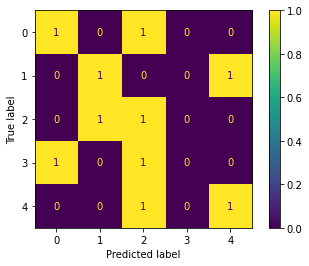

1/1 [==============================] - 2s 2s/step
SVM1 Accuracy =  0.8


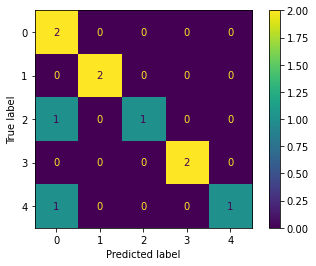

1/1 [==============================] - 2s 2s/step
SVM1 Accuracy =  0.4


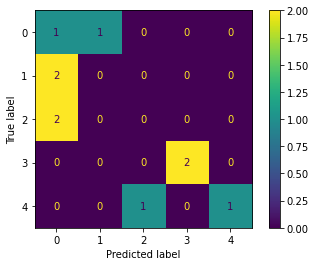

1/1 [==============================] - 2s 2s/step
SVM1 Accuracy =  0.8


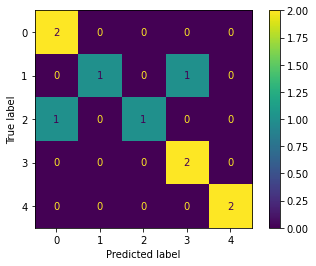

1/1 [==============================] - 3s 3s/step
SVM1 Accuracy =  0.9


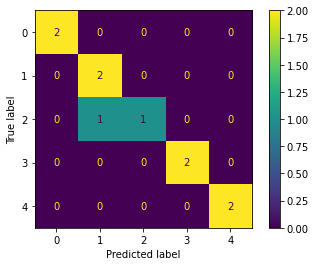

1/1 [==============================] - 3s 3s/step
SVM1 Accuracy =  0.7


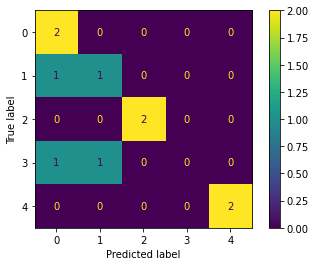

1/1 [==============================] - 2s 2s/step
SVM1 Accuracy =  0.5


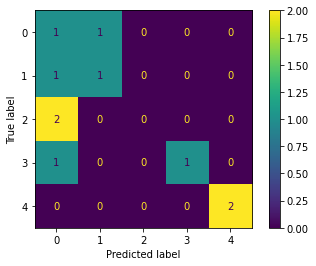

1/1 [==============================] - 3s 3s/step
SVM1 Accuracy =  0.8


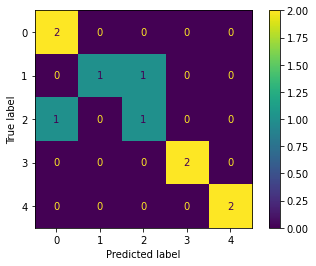

1/1 [==============================] - 3s 3s/step
SVM1 Accuracy =  0.8


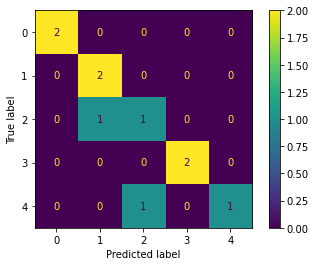

1/1 [==============================] - 2s 2s/step
SVM1 Accuracy =  0.6


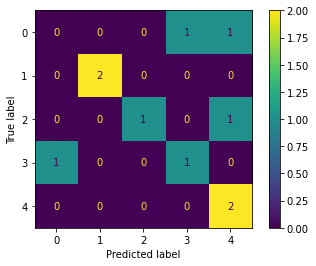

In [34]:
# Variable for keeping count of split we are executing
j = 0

# K-fold Train and test for each split
for train_idx, val_idx in list(kfold.split(X_train_scaled,y_train)):

    x_train_df = X_train_scaled[train_idx]
    x_valid_df = X_train_scaled[val_idx]
    
    y_train_df = y_train[train_idx]
    y_valid_df = y_train[val_idx]
    
    feature_extractor=VGG_model.predict(x_train_df)
    features = feature_extractor.reshape(feature_extractor.shape[0], -1)


    SVM1.fit(features, y_train_df)

    #Send test data through same feature extractor process
    X_test_feature = VGG_model.predict(x_valid_df)
    X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)


    #Predict using the trained RF model. 
    prediction_SVM1 = SVM1.predict(X_test_features)


    print ("SVM1 Accuracy = ", metrics.accuracy_score(y_valid_df, prediction_SVM1))
    kfold_acc.append(metrics.accuracy_score(y_valid_df, prediction_SVM1))
    
    #confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_valid_df, prediction_SVM1)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

    cm_display.plot()
    plt.show()

In [35]:
mean(kfold_acc)

0.5752380952380952

In [31]:
for layer in VGG_model.layers:
    layer.trainable = False
feature_extractor=VGG_model.predict(X_train_scaled)
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

 4/47 [=>............................] - ETA: 2:53

KeyboardInterrupt: 

In [ ]:
SVM1 = svm.SVC(kernel='poly', degree=5, C=3)
SVM1.fit(features, y_train)

In [28]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test_scaled)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

4/4 [==============================] - 12s 3s/step


In [29]:
#Predict using the trained RF model. 
prediction_SVM1 = SVM1.predict(X_test_features)

SVM1 Accuracy =  0.35


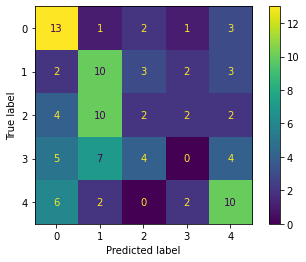

In [30]:
print ("SVM1 Accuracy = ", metrics.accuracy_score(y_test, prediction_SVM1))

confusion_matrix = metrics.confusion_matrix(y_test, prediction_SVM1)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)

cm_display.plot()
plt.show()